## Part 3: Portfolio insurance strategy ##
For this task, assume a fictive investor with an investment horizon of T ∗ = 1 year, planning to invest 10,000 euros. Assume that the investor has the possibility to invest in a stock or index, and put options for portfolio insurance purposes.

In [1]:
!pip install yahoo_fin numpy pandas matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


### 3.1 Performance analysis (without risk management) ###
Use a Monte-Carlo simulation to derive the payoff/return distribution at the end of the investment horizon T ∗ of an investment in the stock/index. Calculate meaningful perfor- mance and risk measures and explain.

In [2]:
from yahoo_fin import stock_info as si
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Fetch historical data for S&P 500
ticker = "^GSPC"
data = si.get_data(ticker, start_date="2000-07-09", end_date="2024-07-09")
data = data[['adjclose']]  # Use adjusted close prices
data.rename(columns={"adjclose": "price"}, inplace=True)


#### 3.1 Results ####
Based on a Monte-Carlo simulation with 10,000 trials, the projected
average return on the S&P500 will be ~7.51%, yielding 10751.20 with
standard deviation of 2076.74 and a 5% VaR loss of -2347.06. With
risk management by using 10% of initial wealth to buy 5% OTM puts,
the average portfolio value is 10001.35 with a standard deviation of
120.71 and a 5% VaR loss of -197.44. Since dispersion
and VaR loss is lower with puts, the protection is significant but at the
cost of returns.

Mean Final Value: 10751.20
Standard Deviation of Final Value: 2076.74
Value at Risk (95%): -2347.0598540563014


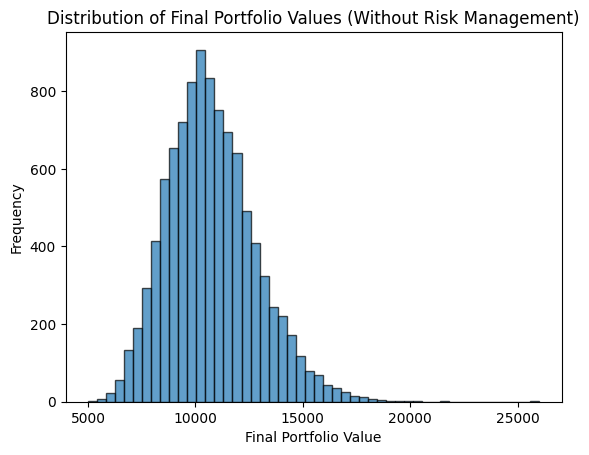

In [ ]:
# Parameters for Monte-Carlo simulation
initial_investment = 10000
num_simulations = 10000
investment_horizon = 1 # 1 year

# Calculate mean returns and standard deviation of returns
daily_returns = data['price'].pct_change().dropna()
mean_return = daily_returns.mean()
std_return = daily_returns.std() 
data['returns'] = daily_returns

# Monte-Carlo simulation using the mean_returns and std_return, 10k simulations
final_values = []
np.random.seed(42)

for i in range(num_simulations):
    daily_returns_simulated = np.random.normal(mean_return, std_return, investment_horizon * 252)
    price_simulated = initial_investment * (1 + daily_returns_simulated).cumprod()
    final_values.append(price_simulated[-1])


# Performance and risk measures
final_values = np.array(final_values)
mean_final_value = np.mean(final_values)
std_final_value = np.std(final_values)
VaR_95 = np.percentile(final_values, 5)

print(f"Mean Final Value: {mean_final_value:.2f}")
print(f"Standard Deviation of Final Value: {std_final_value:.2f}")

## VAR will need to calculate with a little bit more precision
loss = initial_investment - VaR_95
print(f"Value at Risk (95%): {-loss}")

# Plot histogram of final values
plt.hist(final_values, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Final Portfolio Values (Without Risk Management)')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.show()

### 3.2 Performance analysis (with risk management) ###
Implement a portfolio insurance strategy by including put options to hedge the portfolio against downside risks. Consider fictitious puts, which prices are based on the historical volatility of the underlying, and analyze the impact of
i) the fraction of initial wealth invested in put options, and
ii) the strike K of the put options
on the performance and risk measures of the resulting portfolio. Illustrate and discuss
your observations.

#### 3.2 Results ####
Adjusting the fraction of the investments to put options affects the
overall distribution of returns. The premiums paid shifts the returns
curve to the left as returns are lower but protection is greater, so the
95% VaR significantly falls from ~-2300 euros to ~-200 euros.
However, by observation, adding puts leads to diminishing returns,
meaning VaR falls initially but increases as more protection is included
and eats into returns. The strike price affects the portfolio’s overall
value but also protection. Lower strike puts increased portfolio values
in base, average cases (because of lower premiums) but leads to
significantly lower portfolio values in downside cases (because of lower
insurance).

Mean Final Value (With Insurance): 10003.52
Standard Deviation of Final Value (With Insurance): 120.52
Value at Risk (95%) (With Insurance): -194.89001193959302


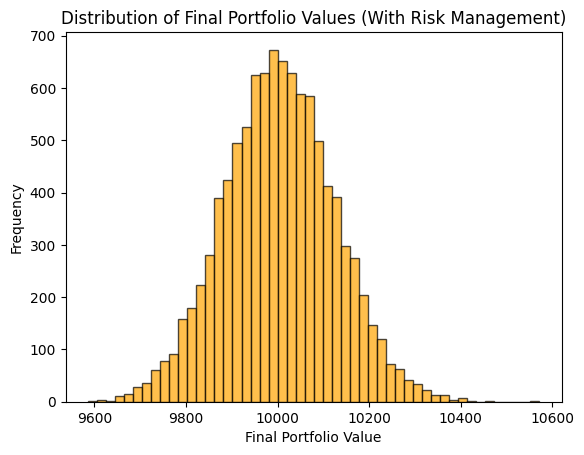

In [4]:
# Define put options parameters
strike_price = 0.95 * data['price'].iloc[-1]  # Assume 5% out-of-the-money put option
option_fraction = 0.1  # Fraction of initial wealth invested in put options

# Function to calculate put option payoff
def put_option_payoff(stock_price, strike_price):
    return max(strike_price - stock_price, 0)

# Monte-Carlo simulation with portfolio insurance
final_values_with_insurance = []

for _ in range(num_simulations):
    daily_returns = np.random.normal(mean_return, std_return, investment_horizon)
    price_series = initial_investment * np.cumprod(1 + daily_returns)
    final_stock_price = price_series[-1]
    
    put_payoff = put_option_payoff(final_stock_price, strike_price)
    final_value_with_insurance = final_stock_price + option_fraction * put_payoff
    final_values_with_insurance.append(final_value_with_insurance)

# Performance and risk measures with insurance
final_values_with_insurance = np.array(final_values_with_insurance)
mean_final_value_with_insurance = np.mean(final_values_with_insurance)
std_final_value_with_insurance = np.std(final_values_with_insurance)
VaR_95_with_insurance = np.percentile(final_values_with_insurance, 5)

print(f"Mean Final Value (With Insurance): {mean_final_value_with_insurance:.2f}")
print(f"Standard Deviation of Final Value (With Insurance): {std_final_value_with_insurance:.2f}")
loss_with_insurance = initial_investment - VaR_95_with_insurance
print(f"Value at Risk (95%) (With Insurance): {-loss_with_insurance}")

# Plot histogram of final values with insurance
plt.hist(final_values_with_insurance, bins=50, edgecolor='k', alpha=0.7, color='orange')
plt.title('Distribution of Final Portfolio Values (With Risk Management)')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.show()

### 3.3 Stress scenario analysis ###
For a specific portfolio allocation from Problem IX, consider that the volatility for pricing purposes of the options equals the historical volatility of the underlying ±5 percentage points and/or a sudden drop in the stock/index price by 20% after half a year. Compare the results and explain.

In [5]:
!pip install blackscholes


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


#### 3.3 Results #### 
The volatility obviously affects the put premiums — the higher the
volatility, the higher the put premiums. The overall mean portfolio
value does not change too much at around ~10k EUR with 5% OTM
puts. However, the VaR changes significantly. Greater volatility leads
to fatter tails, meaning the frequency of losses is higher shown by the
green distribution curve over the orange and blue curves. Losses, in
this case of an additional 5% volatility, could lead to a 5% rate of
losing ~4100 EUR within the next half year. This loss represents 41%
of the portfolio, and therefore shows that a few hundred bps increase
volatility could be extremely material.

Put Option Price for vol = -5.0% : 1.416258111572713
Put Option Price for vol = 0% : 2.3757930490671013
Put Option Price for vol = 5.0% : 3.3778525574076115

Volatility Adjustment: -5.0%
Mean Final Value: 9984.55
Standard Deviation of Final Value: 1437.88
Value at Risk (95%): 7592.77

Volatility Adjustment: 0.0%
Mean Final Value: 10006.46
Standard Deviation of Final Value: 1921.86
Value at Risk (95%): 6816.36

Volatility Adjustment: 5.0%
Mean Final Value: 10031.62
Standard Deviation of Final Value: 2436.33
Value at Risk (95%): 6033.17


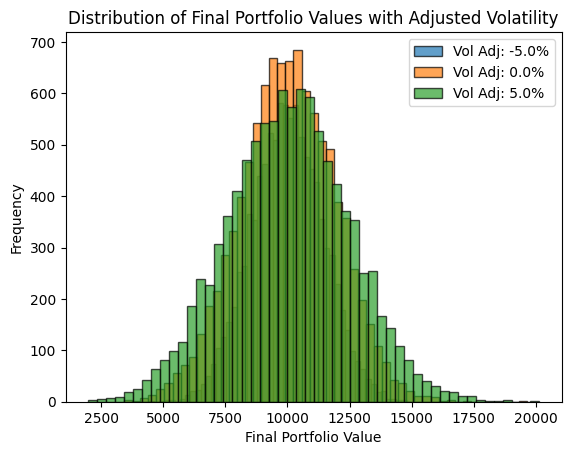

In [6]:
from blackscholes import BlackScholesPut
# Function to perform Monte-Carlo simulation with adjusted volatility
def monte_carlo_simulation_with_adjusted_volatility(vol_adjustment, initial_investment, mean_return, std_return, investment_horizon, strike_price, option_fraction):
    adjusted_std_return = std_return*np.sqrt(252) + vol_adjustment
    #price put options using black scholes formula
    # HERE: problem here is that I am using daily vol instead of yearly, so my calcs are weird,
    # need to adjust to calculate option prices
    S = 5615
    K = strike_price
    T = 1.0
    r = 0.02
    sigma = adjusted_std_return
    q = 0
    put = BlackScholesPut(S=S, K=K, T=T, r=r, sigma=sigma, q=q)
    put.price() 
    print(f"Put Option Price for vol = {vol_adjustment*100}% : {put.price()/100}")

    final_values_with_insurance = []

    for _ in range(num_simulations):
        daily_returns = np.random.normal(mean_return, adjusted_std_return, investment_horizon)
        price_series = initial_investment * np.cumprod(1 + daily_returns)
        final_stock_price = price_series[-1]
        
        put_payoff = put_option_payoff(final_stock_price, strike_price)
        final_value_with_insurance = final_stock_price + option_fraction * put_payoff
        final_values_with_insurance.append(final_value_with_insurance)
    
    return np.array(final_values_with_insurance)

# Perform simulations with adjusted volatilities
vol_adjustments = [-0.05, 0, 0.05]
results = {}

for adj in vol_adjustments:
    results[adj] = monte_carlo_simulation_with_adjusted_volatility(
        adj, initial_investment, mean_return, std_return, investment_horizon, strike_price, option_fraction
    )

# Calculate performance measures for adjusted volatilities
for adj, final_values in results.items():
    mean_final_value = np.mean(final_values)
    std_final_value = np.std(final_values)
    VaR_95 = np.percentile(final_values, 5)
    
    print(f"\nVolatility Adjustment: {adj*100:.1f}%")
    print(f"Mean Final Value: {mean_final_value:.2f}")
    print(f"Standard Deviation of Final Value: {std_final_value:.2f}")
    print(f"Value at Risk (95%): {VaR_95:.2f}")

# Plot histograms of final values with adjusted volatilities
for adj, final_values in results.items():
    plt.hist(final_values, bins=50, edgecolor='k', alpha=0.7, label=f'Vol Adj: {adj*100:.1f}%')

plt.title('Distribution of Final Portfolio Values with Adjusted Volatility')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()